In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy.ma as ma
from scipy.stats.stats import pearsonr, normaltest
from scipy.spatial.distance import correlation
import statsmodels.api as sm

### Importing Data / Setting Seed  / Making Test and Training Sets

In [10]:
data = pd.read_csv('insurance.csv')

#Creating Samples
np.random.seed(2)

train = data.sample(round(data.shape[0]*.8)) # 80%
test = data.drop(train.index)

### Binning BMI

In [4]:
binned_bmi = pd.cut(train['bmi'], [0,18.5,25,30,35,60], right = False, retbins = True)
bins = [0,18.5,25,30,35,60]


train['bmi_binned'] = pd.cut(data['bmi'], bins = bins, right = False)
test['bmi_binned'] = pd.cut(data['bmi'], bins = bins, right = False)

### Current Model

In [5]:
#df = train, formula = 'charges ~ age + binned_bmi*smoker + children + region'

ols_object = smf.ols(formula = 'charges ~ age + sex + bmi_binned*smoker + children + region', data = train)
model = ols_object.fit()
print(model.summary())

#Stats
pred = model.predict(test)

print('RMSE:',np.sqrt(((test.charges - pred)**2).mean()))
print('RSE:', np.sqrt(model.mse_resid))
print('R2:', model.rsquared)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     465.6
Date:                Fri, 10 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:08:34   Log-Likelihood:                -10520.
No. Observations:                1070   AIC:                         2.107e+04
Df Residuals:                    1054   BIC:                         2.115e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

### Residual Plots

<AxesSubplot:xlabel='region'>

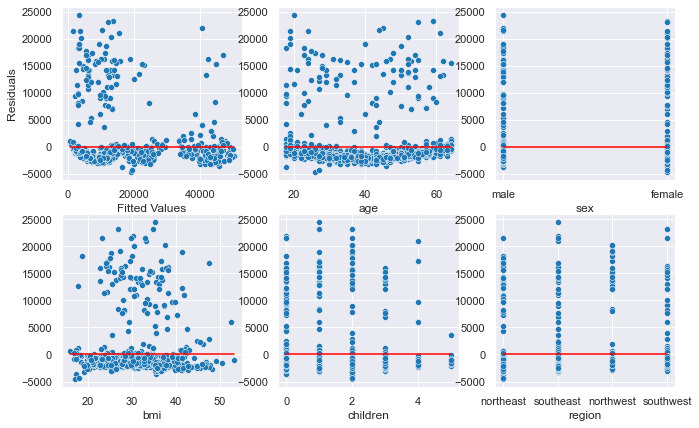

In [6]:
sns.set(font_scale = 1)
plt.rcParams["figure.figsize"] = (11, 7)
fig, axes = plt.subplots(2, 3)

sns.scatterplot(ax = axes[0][0], x = model.fittedvalues, y = model.resid, color = '#1f77b4')
sns.lineplot(ax = axes[0][0], x = [model.fittedvalues.min(), model.fittedvalues.max()], y = [0,0], color = 'red')
axes[0][0].set(xlabel = 'Fitted Values', ylabel = 'Residuals')

sns.scatterplot(ax = axes[0][1], x = train.age, y = model.resid, color = '#1f77b4')
sns.lineplot(ax = axes[0][1], x = [train.age.min(), train.age.max()], y = [0,0], color = 'red')

sns.scatterplot(ax = axes[0][2], x = train.sex, y = model.resid, color = '#1f77b4')
sns.lineplot(ax = axes[0][2], x = [train.sex.min(), train.sex.max()], y = [0,0], color = 'red')

sns.scatterplot(ax = axes[1][0], x = train.bmi, y = model.resid, color = '#1f77b4')
sns.lineplot(ax = axes[1][0], x = [train.bmi.min(), train.bmi.max()], y = [0,0], color = 'red')

sns.scatterplot(ax = axes[1][1], x = train.children, y = model.resid, color = '#1f77b4')
sns.lineplot(ax = axes[1][1], x = [train.children.min(), train.children.max()], y = [0,0], color = 'red')

sns.scatterplot(ax = axes[1][2], x = train.region, y = model.resid, color = '#1f77b4')
sns.lineplot(ax = axes[1][2], x = [train.region.min(), train.region.max()], y = [0,0], color = 'red')

# Stratified Sample

In [44]:
# stratified training and test set by age
train_strata = data.groupby('age', group_keys=False).apply(lambda x: x.sample(frac=0.8))
test_strata = data.drop(train_strata.index)

# add bmi_binned to stratified training

train_strata['bmi_binned'] = pd.cut(data['bmi'], bins = bins, right = False)
test_strata['bmi_binned'] = pd.cut(data['bmi'], bins = bins, right = False)


In [45]:
train_strata.head()

,age,sex,bmi,children,smoker,region,charges,bmi_binned
525,18,female,33.88,0,no,southeast,11482.63485,"[30.0, 35.0)"
194,18,male,34.43,0,no,southeast,1137.46970,"[30.0, 35.0)"
803,18,female,42.24,0,yes,southeast,38792.68560,"[35.0, 60.0)"
781,18,male,41.14,0,no,southeast,1146.79660,"[35.0, 60.0)"
469,18,female,24.09,1,no,southeast,2201.09710,"[18.5, 25.0)"


In [46]:
#df = train_strata, formula = 'charges ~ age + binned_bmi*smoker + children + region'

ols_object = smf.ols(formula = 'charges ~ age + sex + bmi_binned*smoker + children + region', data = train_strata)
model = ols_object.fit()
print(model.summary())

#Stats
pred = model.predict(test_strata)

print('RMSE:',np.sqrt(((test_strata.charges - pred)**2).mean()))
print('RSE:', np.sqrt(model.mse_resid))
print('R2:', model.rsquared)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     454.2
Date:                Fri, 10 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:30:22   Log-Likelihood:                -10466.
No. Observations:                1067   AIC:                         2.096e+04
Df Residuals:                    1051   BIC:                         2.104e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

<AxesSubplot:xlabel='region'>

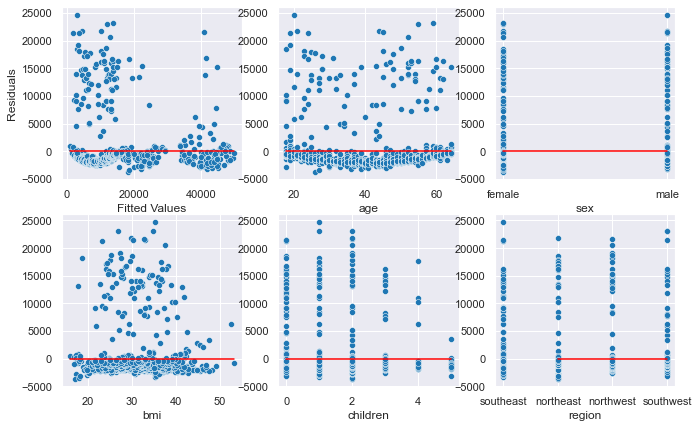

In [47]:
sns.set(font_scale = 1)
plt.rcParams["figure.figsize"] = (11, 7)
fig, axes = plt.subplots(2, 3)
train = train_strata

sns.scatterplot(ax = axes[0][0], x = model.fittedvalues, y = model.resid, color = '#1f77b4')
sns.lineplot(ax = axes[0][0], x = [model.fittedvalues.min(), model.fittedvalues.max()], y = [0,0], color = 'red')
axes[0][0].set(xlabel = 'Fitted Values', ylabel = 'Residuals')

sns.scatterplot(ax = axes[0][1], x = train.age, y = model.resid, color = '#1f77b4')
sns.lineplot(ax = axes[0][1], x = [train.age.min(), train.age.max()], y = [0,0], color = 'red')

sns.scatterplot(ax = axes[0][2], x = train.sex, y = model.resid, color = '#1f77b4')
sns.lineplot(ax = axes[0][2], x = [train.sex.min(), train.sex.max()], y = [0,0], color = 'red')

sns.scatterplot(ax = axes[1][0], x = train.bmi, y = model.resid, color = '#1f77b4')
sns.lineplot(ax = axes[1][0], x = [train.bmi.min(), train.bmi.max()], y = [0,0], color = 'red')

sns.scatterplot(ax = axes[1][1], x = train.children, y = model.resid, color = '#1f77b4')
sns.lineplot(ax = axes[1][1], x = [train.children.min(), train.children.max()], y = [0,0], color = 'red')

sns.scatterplot(ax = axes[1][2], x = train.region, y = model.resid, color = '#1f77b4')
sns.lineplot(ax = axes[1][2], x = [train.region.min(), train.region.max()], y = [0,0], color = 'red')

In [48]:
#df = train_strata, formula = 'charges ~ age + binned_bmi*smoker + children + region'

ols_object = smf.ols(formula = 'charges ~ I(age**2) + bmi_binned*smoker + sex + children + region', data = train_strata)
model = ols_object.fit()
print(model.summary())

#Stats
pred = model.predict(test_strata)

print('RMSE:',np.sqrt(((test_strata.charges - pred)**2).mean()))
print('RSE:', np.sqrt(model.mse_resid))
print('R2:', model.rsquared)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     466.2
Date:                Fri, 10 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:30:31   Log-Likelihood:                -10453.
No. Observations:                1067   AIC:                         2.094e+04
Df Residuals:                    1051   BIC:                         2.102e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

<AxesSubplot:xlabel='region'>

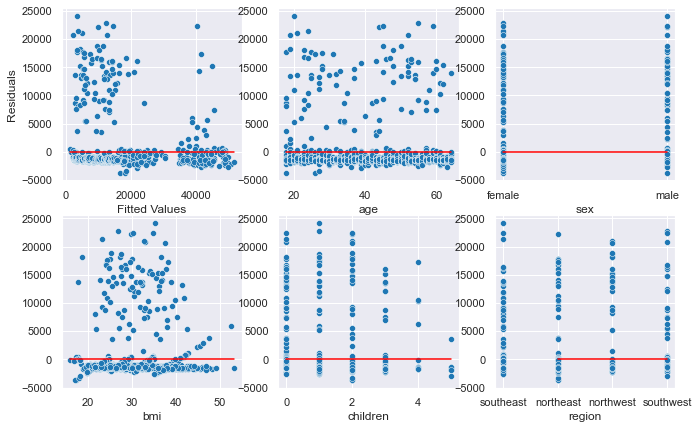

In [49]:
sns.set(font_scale = 1)
plt.rcParams["figure.figsize"] = (11, 7)
fig, axes = plt.subplots(2, 3)
train = train_strata

sns.scatterplot(ax = axes[0][0], x = model.fittedvalues, y = model.resid, color = '#1f77b4')
sns.lineplot(ax = axes[0][0], x = [model.fittedvalues.min(), model.fittedvalues.max()], y = [0,0], color = 'red')
axes[0][0].set(xlabel = 'Fitted Values', ylabel = 'Residuals')

sns.scatterplot(ax = axes[0][1], x = train.age, y = model.resid, color = '#1f77b4')
sns.lineplot(ax = axes[0][1], x = [train.age.min(), train.age.max()], y = [0,0], color = 'red')

sns.scatterplot(ax = axes[0][2], x = train.sex, y = model.resid, color = '#1f77b4')
sns.lineplot(ax = axes[0][2], x = [train.sex.min(), train.sex.max()], y = [0,0], color = 'red')

sns.scatterplot(ax = axes[1][0], x = train.bmi, y = model.resid, color = '#1f77b4')
sns.lineplot(ax = axes[1][0], x = [train.bmi.min(), train.bmi.max()], y = [0,0], color = 'red')

sns.scatterplot(ax = axes[1][1], x = train.children, y = model.resid, color = '#1f77b4')
sns.lineplot(ax = axes[1][1], x = [train.children.min(), train.children.max()], y = [0,0], color = 'red')

sns.scatterplot(ax = axes[1][2], x = train.region, y = model.resid, color = '#1f77b4')
sns.lineplot(ax = axes[1][2], x = [train.region.min(), train.region.max()], y = [0,0], color = 'red')

Attempt stratification with smoker data

In [55]:
# stratified training and test set by smoker
train_strata = data.groupby('smoker', group_keys=False).apply(lambda x: x.sample(frac=0.8))
test_strata = data.drop(train_strata.index)

# add bmi_binned to stratified training

train_strata['bmi_binned'] = pd.cut(data['bmi'], bins = bins, right = False)
test_strata['bmi_binned'] = pd.cut(data['bmi'], bins = bins, right = False)

In [58]:
#df = train_strata, formula = 'charges ~ age + binned_bmi*smoker + children + region'

ols_object = smf.ols(formula = 'charges ~ I(age**2) + bmi_binned*smoker + sex + children + region', data = train_strata)
model = ols_object.fit()
print(model.summary())

#Stats
pred = model.predict(test_strata)

print('RMSE:',np.sqrt(((test_strata.charges - pred)**2).mean()))
print('RSE:', np.sqrt(model.mse_resid))
print('R2:', model.rsquared)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     476.0
Date:                Fri, 10 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:34:56   Log-Likelihood:                -10472.
No. Observations:                1070   AIC:                         2.098e+04
Df Residuals:                    1054   BIC:                         2.106e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------